In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from utils.make_dataset import *
from utils.transforms import *
import cv2
from glob import glob
import os
import re
import torch
import model


Populating the interactive namespace from numpy and matplotlib


In [2]:
torch.cuda.is_available()

True

In [3]:
data_folder_path = 'MRI_images_new'

In [4]:
for i in range(1,2):
    images = np.load('data/{}.npy'.format(i), allow_pickle=True) 
    print(images.shape)


(25, 480, 240)


In [5]:
#for img in data[0]:
    #figure(figsize=(8, 8), dpi=80)
    #imgplot = plt.imshow(img)
    #plt.show()

In [19]:
def pre_tranforms(projection, task, drop_researh_tags=['DIRTY'], researh_type=None, conjunction=True, resize=True, dim=(256, 256), crop=True, best_slice = False):
    marking = pd.read_csv('labels/marking_arrays.csv', usecols=['path', 'parent path', 'patient number',
                                                                'researh type', 'projection', 'hip side',
                                                                'cartialge lesion',
                                                                'subchondral cysts', 'bone marrow lesion', 'synovitis',
                                                                'ill', 'best_slice', 'bad_research', 'rectangle'])

    bad_mark = '-'
    proc_marking = marking[marking['bad_research'] != bad_mark]
    proc_marking = proc_marking[proc_marking['projection'] == projection]
    if researh_type:
        if conjunction:
            proc_marking_1 = proc_marking[proc_marking['researh type'].str.contains(researh_type[0], na=False)]
            proc_marking_2 = proc_marking[proc_marking['researh type'].str.contains(researh_type[1], na=False)]
            proc_marking_3 = proc_marking[proc_marking['researh type'].str.contains(researh_type[2], na=False)]
            proc_marking  = pd.concat([proc_marking_1, proc_marking_2,  proc_marking_3])
            proc_marking = proc_marking.drop_duplicates()
        elif not conjunction:
            proc_marking = proc_marking[proc_marking['researh type'].str.contains(researh_type[0], na=False) & proc_marking['researh type'].str.contains(researh_type[1], na=False)]


    for tag in drop_researh_tags:
        mask = proc_marking['researh type'].str.contains(tag, na=False)
        proc_marking = proc_marking[~mask]

    data_dict = {}
    length = 0

    for i, row in enumerate(proc_marking.iloc):
        label = {}
        data = {}

        path = row['path']
        raw_row = row['rectangle']
        box = re.findall(r"\d+", raw_row)
        integer_map = map(int, box)
        box = list(integer_map)
        try:


            images = np.load(path[2:], allow_pickle=True)
        except ValueError:
            print('not loaded ', path)
        else:
            if len(images.shape )>2:

                data['label'] = int(row[task])
                if crop:
                    images = square_crop(images, box)
                if best_slice:
                    slice = int(row['best_slice'])
                    images = slice_crop(images, 0.2, slice)
                if resize:
                    images = resize_cv2(images, dim)
                    
                #images = normalize_images_v2(images)
                #images = np.stack((images, contrast_stretch(images, n=2),equalize_clahe(images) ), axis=1)
                #images = normalize_images_v1(images)

                data['image'] = images
                data['best_slice'] = int(row['best_slice'])
                data_dict[path] = data                
                length += 1
    print('dataset len', length)
    assert len(list(data_dict.keys()))==length
    return length, data_dict



In [42]:
_, data_dict = pre_tranforms('cor', 'ill',
                             drop_researh_tags=['DIRTY'],
                             researh_type=['T1', '-', '-'], 
                             conjunction=True, resize=True,
                             dim=(256, 256), crop=True, best_slice = False)

dataset len 136


In [ ]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):

    assert len(image.shape)==2
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma,  cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    return map_coordinates(image, indices, order=1).reshape(shape)

In [17]:
img_deformed = elastic_transform(img, 40, 2)
img_deformed.min()

0

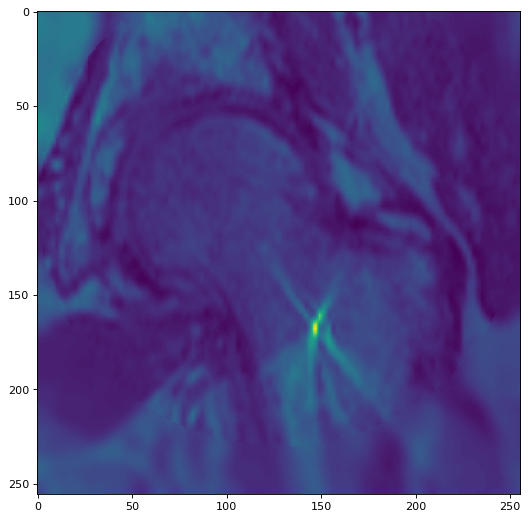

In [18]:
i = 2
img = data_dict[keys[i]]['image'][data_dict[keys[i]]['best_slice']]
masked_img = create_blur_mask(img,n=0.8,k=1)
figure(figsize=(8, 8), dpi=80)
imgplot = plt.imshow(masked_img)
plt.show()

In [102]:
#for img in data[0]:
    #figure(figsize=(8, 8), dpi=80)
    #imgplot = plt.imshow(img)
    #plt.show()

In [ ]:
bi_path = 'data_npy/bilateral'

if not os.path.exists('data_npy'):
    os.makedirs('data_npy')
if not os.path.exists(bi_path):
    os.makedirs(bi_path)    

for key in full_dict.keys():
    print(key)        
    savepath = os.path.join(bi_path, key.split('/')[-2])
    
    slices = load_scan(key)    
    images = get_images(slices, resize=False)
    
    outname = savepath +'_L.npy'  
    print(outname)
    #numpy.save(L_outname, L_images)

    

In [ ]:
if not os.path.exists('bone_nobone'):
    os.makedirs('bone_nobone')
    
for key in full_dict.keys():
    slices = load_scan(path)
    images = get_images(slices, dim=(512, 512))
    for image in images:
        if i<400:
            #outname = os.path.join('bone_nobone', f'{i:04}'+'.jpg')  
            #cv2.imwrite(outname, image)
            i += 1